In [2]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 120
rcParams["savefig.dpi"] = 120

import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob

from astropy.io import fits
from astropy.stats import BoxLeastSquares as BLS

from bls import bls
import local_linear as ll

import batman #Bad-Ass Transit Model cAlculatioN
import astropy.units as u
from astropy.constants import G, R_sun, M_sun, R_jup, M_jup, R_earth, M_earth

2.51796501315597 d


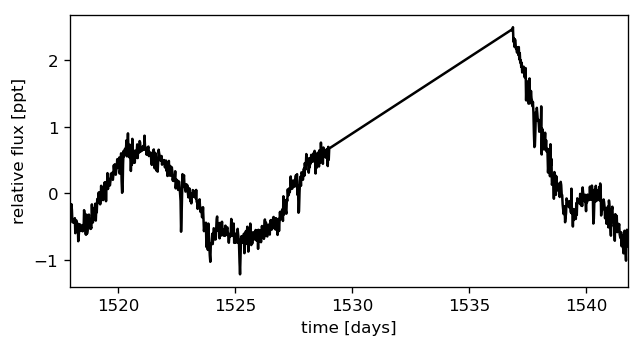

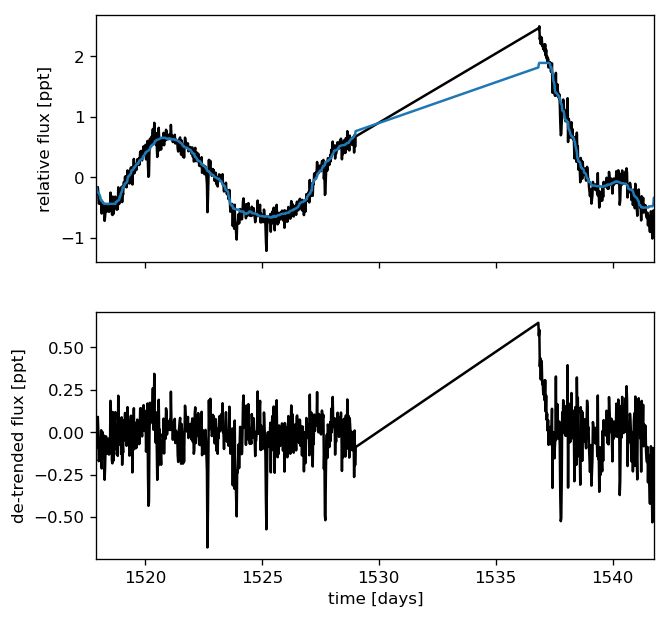

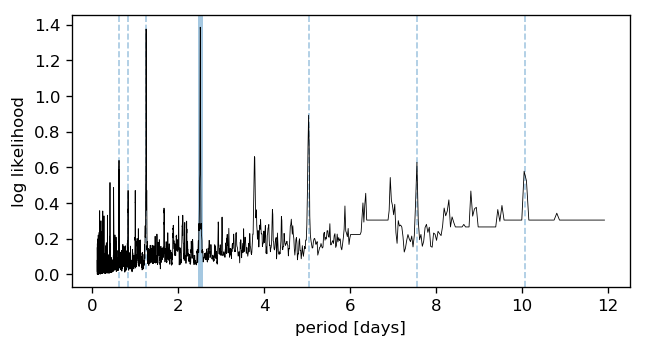

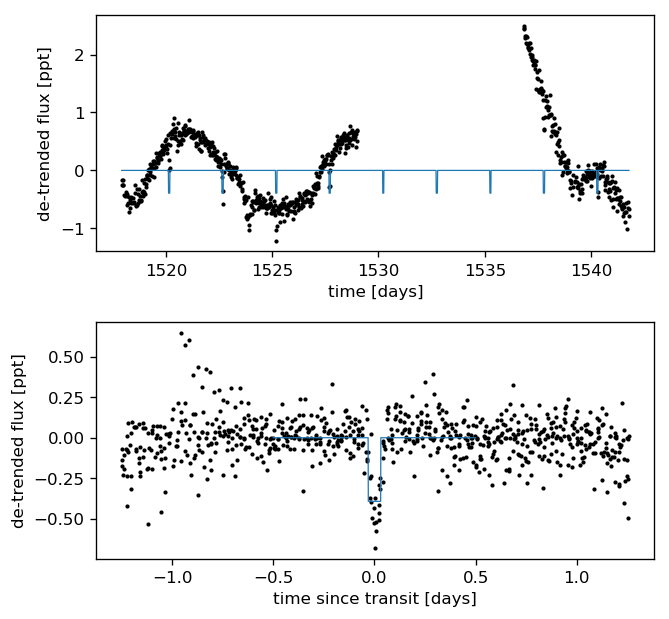

In [23]:
tess_file = 'tess_1562404.fits'#sys.argv[1]

with fits.open(tess_file) as tess_data:
    data = tess_data[1].data
    t = data["TIME"]
    y = data["SAP_FLUX"]
    q = data["QUALITY"]

# This is from the EVEREST source. These are the flagged data points
# that should be removed. Ref: https://github.com/rodluger/everest
m = np.isfinite(t) & np.isfinite(y)
for b in [1, 2, 3, 4, 5, 6, 7]:
    m &= (q & (2 ** (b - 1))) == 0

t = np.ascontiguousarray(t[m], dtype=np.float64) * u.day
y = np.ascontiguousarray(y[m], dtype=np.float64)
y = (y / np.median(y) - 1)*1e3

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))
ax.plot(t, y, "k")
ax.set_xlim(t.min().value, t.max().value)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative flux [ppt]");

from scipy.signal import medfilt
trend = medfilt(y, 45)
mu = np.median(y)
y_filt =(y - trend)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
ax.plot(t, y, "k")
ax.plot(t, trend)
ax.set_ylabel("relative flux [ppt]")

ax = axes[1]
ax.plot(t, y_filt, "k")
ax.set_xlim(t.min().value, t.max().value)
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]");

#durations = np.linspace(1.4, 2.2, 100) * u.h
durations = 1.47 * u.h # 2.170 in report, incorrect
model = BLS(t, y_filt)
results = model.autopower(durations, frequency_factor=5.0)
#print(results)

# Find the period of the peak
period = results.period[np.argmax(results.power)]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Highlight the harmonics of the peak period
ax.axvline(period.value, alpha=0.4, lw=3)
for n in range(2, 5):
    ax.axvline(n*period.value, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period.value / n, alpha=0.4, lw=1, linestyle="dashed")
#ax.axvline(1.071, alpha=0.4, c='r', lw=1, linestyle="solid")

# Plot the periodogram
ax.plot(results.period, results.power, "k", lw=0.5)

#ax.set_xlim(results.period.min().value, results.period.max().value)
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood");

#period = 1.071*u.d

#print(model.compute_stats(period, duration, t0))

# Extract the parameters of the best-fit model
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

fig, axes = plt.subplots(2, 1, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3)

# Plot the light curve and best-fit model
ax = axes[0]
ax.plot(t, y, ".k", ms=3)
x = np.linspace(t.min(), t.max(), 3*len(t))
f = model.model(x, period, duration, t0)
#ax.set_xlim(1481,1483)
#ax.set_xlim(1520,1525)
ax.plot(x, f, lw=0.75)
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]");

# Plot the folded data points within 0.5 days of the transit time
ax = axes[1]
x = (t - t0 + 0.5*period) % period - 0.5*period
m = np.abs(x) < 0.5 * u.day
ax.plot(x, y_filt, ".k", ms=3)

# Over-plot the best fit model
x = np.linspace(-0.5, 0.5, 1000) * u.day
f = model.model(x + t0, period, duration, t0)
ax.plot(x, f, lw=0.75)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("de-trended flux [ppt]");

print (period)